In [93]:
#The purpose of this script is to parse the raw clipper output to clusters for analysis as well
#as the RT stops to use
#NOTE - this script uses the file used to make the bam file for clipper. need to find the original file used to make the bam file

#the first part of this script uses the original clipper output and just uses it for normalized comparison. We will also bring in the gene expression normalization and plotting

#the second half of this script begins to use the functions from FAST-iCLIP to isolate individual RT stops from CLIPPER. There are some problems with this including duplicates and a mismatch between total clipper reads and RT stop reads in the clipper window
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline

In [88]:
def makeClusterCenter(windowsFile):
	# Usage: Generate a file of cluster centers.
	# Input: Raw CLIPper output file.
	# Output: File with coordinates for the center of each CLIPper cluster.
	cleanBed = cleanBedFile(windowsFile)
	centers=cleanBed.replace('.bed','.clusterCenter')
	f = open(centers, 'w')
	with open(cleanBed, 'r') as infile:
		for line in infile:
			elementList = line.strip().split('\t')
			diff=abs(int((int(elementList[1])-int(elementList[2]))/2))
			f.write(elementList[0]+'\t'+str(int(elementList[1])+diff)+'\t'+str(int(elementList[1])+diff+1)+'\n')
	f.close()
	return centers

In [109]:
#get the clipper data and move it to a format that works
#delete the apex, clean up the gene, keep everything else
#also flip the order so that counts is at the end
#DMSO - as a column of 0's to the end
clipper_file = open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl").readlines()
clipper_list = []
for line in clipper_file:
    line=line.strip().split('\t')
    read_count = line[3].split('_')[-1]
    gene = line[3].split('.')[0]
    del line[3]
    line.insert(3,read_count)
    line.insert(3,line[5])
    line.insert(3,gene)
    del line[-1]
    del line[-1]
    del line[-1]
    del line[-1]
    line.append(0)
    clipper_list.append(line)
with open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned",'w') as outfile:
    writer = csv.writer(outfile,'textdialect')
    writer.writerows(clipper_list)

#TAM - add a column of 0's before the score
clipper_file = open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl").readlines()
clipper_list = []
for line in clipper_file:
    line=line.strip().split('\t')
    read_count = line[3].split('_')[-1]
    gene = line[3].split('.')[0]
    del line[3]
    line.insert(3,read_count)
    line.insert(3,line[5])
    line.insert(3,gene)
    del line[-1]
    del line[-1]
    del line[-1]
    del line[-1]
    line.insert(5,0)
    clipper_list.append(line)
with open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned",'w') as outfile:
    writer = csv.writer(outfile,'textdialect')
    writer.writerows(clipper_list)

In [113]:
###PROBLEM - WE ARE NOT MERGING BY STRAND SO THERE ARE A FEW OVERLAPS BY STRAND THAT ARE FAILING
#Merge the clipper clusters together to deal with duplicates
#Prevent bookended clusters from merging together with -d -1
#Now count the number of commas in the gene column and divide the 5th column by 3
#DMSO
!bedtools merge -i hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned -c 4,5,6,7 -o distinct,distinct,sum,sum -d -1 > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged
inlist = []
with open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged") as f:
    for line in f:
        line = line.strip().split('\t')
        if "," in line[3]:
            count = line[3].count(',')+1
            corrected_read_count = int(line[5])/count
            line[5]=corrected_read_count
        inlist.append(line)
with open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected",'w') as f:
    writer = csv.writer(f,"textdialect")
    writer.writerows(inlist)

#TAM
!bedtools merge -i hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned -c 4,5,6,7 -o distinct,distinct,sum,sum -d -1 > hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged
inlist = []
with open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged") as f:
    for line in f:
        line = line.strip().split('\t')
        if "," in line[3]:
            count = line[3].count(',')+1
            corrected_read_count = int(line[6])/count
            line[6]=corrected_read_count
        inlist.append(line)
with open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected",'w') as f:
    writer = csv.writer(f,"textdialect")
    writer.writerows(inlist)

                       start       end  hnM_DMSO   hnM_TAM  hnM_DMSO_1  \
start               1.000000  1.000000 -0.001845 -0.001629   -0.001845   
end                 1.000000  1.000000 -0.001845 -0.001629   -0.001845   
hnM_DMSO           -0.001845 -0.001845  1.000000  0.922804    1.000000   
hnM_TAM            -0.001629 -0.001629  0.922804  1.000000    0.922804   
hnM_DMSO_1         -0.001845 -0.001845  1.000000  0.922804    1.000000   
hnM_TAM_1          -0.001629 -0.001629  0.922804  1.000000    0.922804   
log2ratio_TAM-DMSO  0.016901  0.016901 -0.012941  0.013040   -0.012941   

                    hnM_TAM_1  log2ratio_TAM-DMSO  
start               -0.001629            0.016901  
end                 -0.001629            0.016901  
hnM_DMSO             0.922804           -0.012941  
hnM_TAM              1.000000            0.013040  
hnM_DMSO_1           0.922804           -0.012941  
hnM_TAM_1            1.000000            0.013040  
log2ratio_TAM-DMSO   0.013040            1.

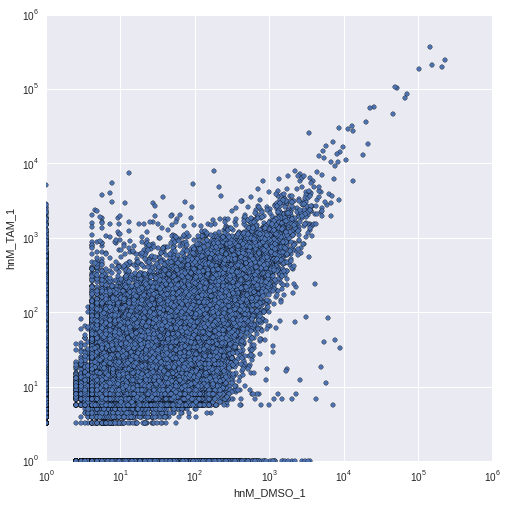

In [120]:
#NOTE - I am using the best clipper output so far using the yeo lab parameters

#The purpose of this is to write a script to generate normalized reads in each sample based on total library size
#and then print this out to a normalized file

#Then the script will overlap the RT stops within a user defined region (i.e.50 bp) to generate clusters of RT stops

#Also the script will plot the normalized data 

#Then load these files into dataframes
DMSO_df = pd.read_csv('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected',sep='\t',header = None,names = ['chrom','start','end','gene','strand','reads_dmso','reads_tam'])
TAM_df = pd.read_csv('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected',sep='\t',header = None,names = ['chrom','start','end','gene','strand','reads_dmso','reads_tam'])
#now calculate and store the total number of RT stops as a scalar to divide by and then multiply
#DMSO
total_reads = DMSO_df.reads_dmso.sum()
DMSO_df.reads_dmso = DMSO_df.reads_dmso.mul(1e7/total_reads)
#TAM
total_reads = TAM_df.reads_tam.sum()
TAM_df.reads_tam = TAM_df.reads_tam.mul(1e7/total_reads)

#save the dataframes as beds
df_list = [DMSO_df,TAM_df]
file_names = ['hnM_DMSO','hnM_TAM']
counter = 0
for df in df_list:
    df.to_csv(file_names[counter]+'_normalized.bed',sep='\t',index = False,header = False)
    counter += 1

#now merge together into new clusters based on 20 nucleotides (This is what the Black RbFox paper did)
#PROBLEM - NOT COMBINING THE DATA CORRECTLY - write a function to fix this as fix_merge
!bedtools merge -i hnM_DMSO_normalized.bed -d 20 -c 4,5,6,7 -o distinct,distinct,sum,sum > hnM_DMSO_normalized_merge.bed
!bedtools merge -i hnM_TAM_normalized.bed -d 20 -c 4,5,6,7 -o distinct,distinct,sum,sum > hnM_TAM_normalized_merge.bed

def fix_merge(mergefile):
    fix_list = []
    with open(mergefile) as f:
        for line in f:
            line = line.strip().split('\t')
            gene_set = set(line[3].split(','))
            line[3] = list(gene_set)
            strand_set = set(line[4].split(','))
            line[4] = list(strand_set)
            fix_list.append(line)
    with open(str(mergefile).replace('.bed','fixed.bed')) as f:
        writer = csv.writer(f,'textdialect')
        writer.writerows(fix_list)
        
            
#now overlap the different samples. Black Rbfox paper took intersecting clusters and compared the read count between only those that intersected. There was no information about the clusters that did not intersect. 

#now I need to merge the DMSO and TAM merged clusters so that I can have a common set of clusters
#To do this, concat together the merges and then remerge but do not have a d
!cat hnM_DMSO_normalized_merge.bed hnM_TAM_normalized_merge.bed > hnM_DMSO_TAM.bed
!bedtools sort -i hnM_DMSO_TAM.bed > hnM_DMSO_TAM_sorted.bed
!bedtools merge -i hnM_DMSO_TAM_sorted.bed -c 4,5,6,7 -o distinct,distinct,sum,sum > hnM_DMSO_TAM_sorted_merged.bed

#take the final union bedgraph and import to pandas so I can calculate the fold change and log2ratio of the samples
header_list=['chrom','start','end','ens_gene','strand','hnM_DMSO','hnM_TAM']
hnM_DMSO_TAM_final_union_df = pd.read_csv('hnM_DMSO_TAM_sorted_merged.bed',sep='\t',names=header_list)
hnM_DMSO_TAM_final_union_df['hnM_DMSO_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_DMSO']+1,axis=1)
hnM_DMSO_TAM_final_union_df['hnM_TAM_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_TAM']+1,axis=1)
hnM_DMSO_TAM_final_union_df['log2ratio_TAM-DMSO'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: (log(row['hnM_TAM']+1,2)-log(row['hnM_DMSO']+1,2)),axis=1)

#Plot in Matplotlib and compute pearson correlation coefficient
ax = hnM_DMSO_TAM_final_union_df.plot(kind='scatter',x='hnM_DMSO_1',y='hnM_TAM_1',figsize=(8,8),loglog=True,\
                                 xlim=(1,10e5),ylim=(1,10e5))

#compute pearson correlation between each column
print(hnM_DMSO_TAM_final_union_df.corr())

/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

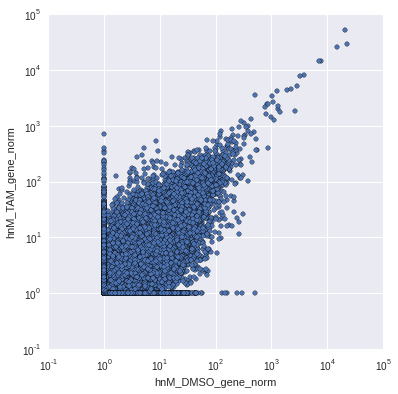

In [131]:
#Bring in the gene expression normalization stuff from master dataframe script here

#take the final union bedgraph and import to pandas so I can calculate the fold change and log2ratio of the samples
header_list=['chrom','start','end','ens_gene','strand','hnM_DMSO','hnM_TAM']
hnM_DMSO_TAM_final_union_df = pd.read_csv('hnM_DMSO_TAM_sorted_merged.bed',sep='\t',names=header_list)
hnM_DMSO_TAM_final_union_df['hnM_DMSO_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_DMSO']+1,axis=1)
hnM_DMSO_TAM_final_union_df['hnM_TAM_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_TAM']+1,axis=1)
hnM_DMSO_TAM_final_union_df['log2ratio_TAM-DMSO'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: (log(row['hnM_TAM']+1,2)-log(row['hnM_DMSO']+1,2)),axis=1)

#now it is time to load the gene expression data
twist_gene_exp_df = pd.read_csv('twist_gene_exp.diff',sep='\t',usecols=[1,2,3,7,8],header=0, names=['ens_gene','gene','gene_coords','twist_d0','twist_d14'])
#now I need to merge the dataframes based on the column ens_gene. The problem is
#that ens_gene is not unique, so there is a loss of clusters
#This merge command just keeps all of the columns that agree on ens_gene
merge_df = pd.merge(hnM_DMSO_TAM_final_union_df,twist_gene_exp_df,on='ens_gene')
#You've got to go back and fix this later... deal with the duplicates somehow
#now add a column with +1 for each and log2ratio
merge_df['twist_d0_1'] = merge_df.apply(lambda row: row['twist_d0']+1,axis=1)
merge_df['twist_d14_1'] = merge_df.apply(lambda row: row['twist_d14']+1,axis=1)
merge_df['log2ratio_d14_d0'] = merge_df.apply(lambda row: (log(row['twist_d14']+1,2)-log(row['twist_d0']+1,2)),axis=1)

#Keep rows with FPKM threshold or more in at least one sample
#Make sure that you use "or" because you want FPKM 5 in at least one sample
fpkm_threshold = 5
merge_df_high_genes = merge_df[(merge_df.twist_d0 >= fpkm_threshold) | (merge_df.twist_d14 >= fpkm_threshold)]

#THIS IS THE CORRECT ONE for plotting!
#Here we take the non-pseudocount values for binding and the pseudocount+1 for gene expression and divide 
#non-pseudocount binding / pseudocount gene expression from that same sample. 
#Then add the pseudocount of 1 to the binding so you can plot on log scale

#now divide by the gene expression in each sample 
#with gene expression normalization - make sure to only use dataframe with genes that are expressed in at least one 
#condition at threshold
# merge_df_high_genes['hnM_DMSO_1_gene_norm'] = 
merge_df_high_genes['hnM_DMSO_gene_norm']= merge_df_high_genes.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_1'])+1),axis=1)
merge_df_high_genes['hnM_TAM_gene_norm'] = merge_df_high_genes.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_1'])+1),axis=1)
#calculate log2ratio of this 
merge_df_high_genes['log2ratio_hnM_TAM_DMSO_gene_norm'] = merge_df_high_genes.apply(lambda row:(log(row['hnM_TAM_gene_norm'],2)-log(row['hnM_DMSO_gene_norm'],2)),axis=1)
#plot a scatter plot
ax_with_gene_norm = merge_df_high_genes.plot(kind='scatter',x='hnM_DMSO_gene_norm',y='hnM_TAM_gene_norm',figsize=(6,6),loglog=True)

/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/sam/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

AttributeError: 'DataFrame' object has no attribute 'tam_bound'

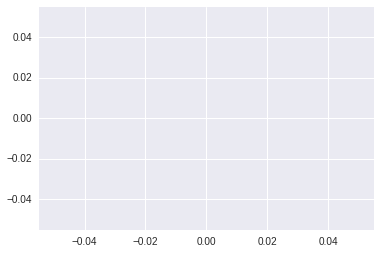

In [152]:
#try to make a prettier figure with colors
#get a dataframe with log2ratio_hnM_TAM_DMSO_gene_norm > or < 0.5
tam_bound = merge_df_high_genes[merge_df_high_genes.log2ratio_hnM_TAM_DMSO_gene_norm >= 1]
tam_bound['category'] = 'tam'
dmso_bound = merge_df_high_genes[merge_df_high_genes.log2ratio_hnM_TAM_DMSO_gene_norm <= -1]
dmso_bound['category'] = 'dmso'
non_diff_bound = merge_df_high_genes[merge_df_high_genes.log2ratio_hnM_TAM_DMSO_gene_norm.abs() <= 1]
non_diff_bound['category'] = 'none'
dfs = [tam_bound,dmso_bound,non_diff_bound]
cat_df = pd.concat(dfs)

#plot a scatter plot
# plot = cat_df.plot(kind='scatter',x='hnM_DMSO_gene_norm',y='hnM_TAM_gene_norm',figsize=(6,6),loglog=True)

group = cat_df.groupby('category')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.tam_bound, group.dmso_bound,group.non_diff_bound, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()


In [146]:
tam_bound.head(10)

,chrom,start,end,ens_gene,strand,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO,...,gene_coords,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0,hnM_DMSO_gene_norm,hnM_TAM_gene_norm,log2ratio_hnM_TAM_DMSO_gene_norm,category
3,chr1,564707,564779,ENSG00000225972,+,0.000000,59.454507,1.000000,60.454507,5.917778,...,chr1:536815-755214,8.66694,26.27960,9.66694,27.27960,1.496691,1.000000,3.179449,1.668777,tam
557,chr1,2192980,2193028,ENSG00000157933,+,0.000000,61.741219,1.000000,62.741219,5.971342,...,chr1:2160133-2241558,20.43520,47.87820,21.43520,48.87820,1.189209,1.000000,2.263165,1.178342,tam
608,chr1,2299015,2299046,ENSG00000116151,-,0.000000,11.433559,1.000000,12.433559,3.636167,...,chr1:2252691-2323146,2.20589,5.19959,3.20589,6.19959,0.951448,1.000000,2.844244,1.508045,tam
611,chr1,2303409,2303445,ENSG00000116151,-,0.000000,9.718525,1.000000,10.718525,3.422035,...,chr1:2252691-2323146,2.20589,5.19959,3.20589,6.19959,0.951448,1.000000,2.567608,1.360425,tam
709,chr1,4804257,4804288,ENSG00000196581,+,0.000000,6.860135,1.000000,7.860135,2.974554,...,chr1:4714791-4843850,7.80731,4.87128,8.80731,5.87128,-0.585026,1.000000,2.168422,1.116646,tam
727,chr1,5945058,5945089,ENSG00000131697,-,0.000000,9.146847,1.000000,10.146847,3.342960,...,chr1:5922870-6161253,5.82837,6.34611,6.82837,7.34611,0.105439,1.000000,2.245128,1.166798,tam
790,chr1,6009429,6009483,ENSG00000131697,-,0.000000,12.005237,1.000000,13.005237,3.701021,...,chr1:5922870-6161253,5.82837,6.34611,6.82837,7.34611,0.105439,1.000000,2.634231,1.397382,tam
793,chr1,6010873,6010968,ENSG00000131697,-,5.439537,21.152084,6.439537,22.152084,1.782414,...,chr1:5922870-6161253,5.82837,6.34611,6.82837,7.34611,0.105439,1.796608,3.879359,1.110542,tam
816,chr1,6019635,6019666,ENSG00000131697,-,0.000000,8.003491,1.000000,9.003491,3.170485,...,chr1:5922870-6161253,5.82837,6.34611,6.82837,7.34611,0.105439,1.000000,2.089487,1.063149,tam
821,chr1,6020484,6020515,ENSG00000131697,-,0.000000,8.003491,1.000000,9.003491,3.170485,...,chr1:5922870-6161253,5.82837,6.34611,6.82837,7.34611,0.105439,1.000000,2.089487,1.063149,tam


count    287718.000000
mean         48.257537
std          41.212417
min           1.000000
25%          30.000000
50%          31.000000
75%          52.000000
max         824.000000
dtype: float64

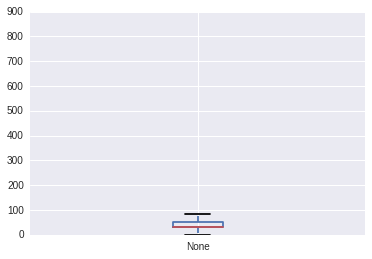

In [139]:
#Plot a boxplot of the cluster sizes
cluster_size = merge_df_high_genes['end']-merge_df_high_genes['start']
cluster_size.plot(kind='box');cluster_size.describe()

In [128]:
#BELOW THIS I WAS TRYING TO FIGURE OUT HOW TO GET SINGLE READS FROM THE CLIPPER DATASETS PER FASTICLIP
#STILL A WORK IN PROGRESS
hnM_DMSO_TAM_final_union_df.describe()

,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO
count,4.194130e+05,4.194130e+05,419413.000000,419413.000000,419413.000000,419413.000000,419413.000000
mean,8.097632e+07,8.097636e+07,23.842847,23.842847,24.842847,24.842847,-0.161399
std,5.632631e+07,5.632631e+07,654.229712,935.292906,654.229712,935.292906,2.660113
min,4.465400e+04,4.468500e+04,0.000000,0.000000,1.000000,1.000000,-11.781038
25%,3.610971e+07,3.610985e+07,0.000000,0.000000,1.000000,1.000000,-2.288472
50%,7.153027e+07,7.153028e+07,3.885383,5.716780,4.885383,6.716780,-0.488436
75%,1.164495e+08,1.164496e+08,10.101996,10.290203,11.101996,11.290203,2.619437
max,2.491478e+08,2.491478e+08,233109.005600,365839.018000,233110.005600,365840.018000,12.322195


In [127]:
merge_df.describe()

,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0
count,4.047750e+05,4.047750e+05,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000
mean,8.132970e+07,8.132975e+07,23.570566,23.672180,24.570566,24.672180,-0.159657,27.383885,31.596450,28.383885,32.596450,-0.270627
std,5.642497e+07,5.642497e+07,664.739793,951.449884,664.739793,951.449884,2.662671,140.264244,261.414367,140.264244,261.414367,1.074709
min,4.465400e+04,4.468500e+04,0.000000,0.000000,1.000000,1.000000,-11.781038,0.000000,0.000000,1.000000,1.000000,-6.460721
25%,3.634299e+07,3.634303e+07,0.000000,0.000000,1.000000,1.000000,-2.288472,3.612610,2.014790,4.612610,3.014790,-0.959912
50%,7.179651e+07,7.179659e+07,3.885383,5.716780,4.885383,6.716780,-0.491282,8.777020,6.156430,9.777020,7.156430,-0.375252
75%,1.166047e+08,1.166048e+08,10.101996,10.290203,11.101996,11.290203,2.619437,19.441200,18.486500,20.441200,19.486500,0.271012
max,2.491478e+08,2.491478e+08,233109.005600,365839.018000,233110.005600,365840.018000,12.322195,9036.280000,11000.600000,9037.280000,11001.600000,8.790504


In [130]:
merge_df_high_genes.describe()

,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0
count,2.877180e+05,2.877180e+05,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000
mean,8.168464e+07,8.168469e+07,25.547576,24.740791,26.547576,25.740791,-0.300191,37.629876,43.861431,38.629876,44.861431,-0.240488
std,5.759095e+07,5.759095e+07,482.836518,931.318386,482.836518,931.318386,2.638221,165.270896,309.224342,165.270896,309.224342,1.208550
min,4.465400e+04,4.468500e+04,0.000000,0.000000,1.000000,1.000000,-11.781038,0.000000,0.000000,1.000000,1.000000,-6.460721
25%,3.585038e+07,3.585043e+07,0.000000,0.000000,1.000000,1.000000,-2.397378,8.001280,5.350500,9.001280,6.350500,-1.072072
50%,7.134767e+07,7.134770e+07,4.662460,5.716780,5.662460,6.716780,-0.753143,13.275800,10.970300,14.275800,11.970300,-0.378848
75%,1.197660e+08,1.197663e+08,11.656150,10.290203,12.656150,11.290203,2.478564,27.570100,26.737100,28.570100,27.737100,0.471193
max,2.491478e+08,2.491478e+08,156335.387400,365839.018000,156336.387400,365840.018000,12.322195,9036.280000,11000.600000,9037.280000,11001.600000,8.790504


In [18]:
import pandas as pd
import numpy as np
import csv
import math
import os
csv.register_dialect("textdialect",delimiter='\t')

In [5]:
#now load from the clipper directory for DMSO for example
#/media/sam/Data1/hnRNPM_iCLIP/iCLIP_analysis/getting_clipper_to_work/clipper_runs/hnM_DMSO_clipper/
clipper_header = ['chr','start','stop','cluster_name','fdr','strand','apex_start','apex_stop']
dmso_clipper_df = pd.read_csv('/media/sam/Data1/hnRNPM_iCLIP/iCLIP_analysis/2016_programmatic_iCLIP_analysis/getting_clipper_to_work/clipper_runs/hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial',sep='\t',header=None,names=clipper_header)

In [6]:
dmso_clipper_df.head()

,chr,start,stop,cluster_name,fdr,strand,apex_start,apex_stop
0,chr1,564511,564516,ENSG00000225972.1_0_16,8.415699e-09,+,564511,564515
1,chr1,564707,564711,ENSG00000225972.1_1_17,2.237303e-10,+,564707,564709
2,chr1,564711,564740,ENSG00000225972.1_2_33,2.362838e-09,+,564728,564732
3,chr1,564740,564779,ENSG00000225972.1_3_54,5.088371e-18,+,564753,564757
4,chr1,565230,565237,ENSG00000225630.1_0_7,6.651387e-04,+,565230,565233


In [19]:
#Need to filter the mergedRT of snoRNAs and miRNAs
def filter_snoRNAs(negAndPosMerged, snoRNAmasker, miRNAmasker):
	# Usage: Filter snoRNA and miRNAs from protein coding reads.
	# Input: .bed file with protein coding reads.
	# Output: snoRNA and miR filtered .bed file.
	program='intersectBed'
	proteinWithoutmiRNAs = negAndPosMerged.replace('.bed','_snoRNAremoved_miRNAremoved.bed')

	cmd1 = "bedtools intersect -a {} -b {} -wa -v -s | sort -k1,1 -k2,2n".format(negAndPosMerged, snoRNAmasker)
	cmd2_1 = "bedtools intersect -a - -b {} -wa -v -s -sorted".format(miRNAmasker)
	cmd2_2 = "awk -F '\\t' 'BEGIN {OFS=\"\\t\"} {print $1,$2,$3,$4 \"_\" NR,$5,$6}'"
	cmd2_3 = proteinWithoutmiRNAs
	cmd = cmd1 + ' | ' + cmd2_1 + ' | ' + cmd2_2 + ' > ' + cmd2_3
	os.system(cmd)
	
	return proteinWithoutmiRNAs

In [22]:
#run the masker to get the proper bed file
snoRNAmasker = "/home/sam/bin/FAST-iCLIP/docs/hg19/snoRNA_reference/sno_coordinates_hg19_formatted.bed"
miRNAmasker = "/home/sam/bin/FAST-iCLIP/docs/hg19/miR_sort_clean.bed"
#DMSO
filter_snoRNAs("hnM_DMSO_clipper/HS_hnRNPM_DMSO_T4_clipper_threshold=2_hg19_allreads.mergedRT.bed",snoRNAmasker,miRNAmasker)
#TAM
filter_snoRNAs("hnM_TAM_clipper/HS_hnRNPM_TAM_T4_clipper_threshold=2_hg19_allreads.mergedRT.bed",snoRNAmasker,miRNAmasker)

'hnM_DMSO_clipper/HS_hnRNPM_DMSO_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved.bed'

In [23]:
#BD merge adjancent clip clusters and remove duplicates
#Just use his script for now
#The reason there are duplicates are that there are some overlapping genes that are counted twice if they are on the same strand.
# added by BD 4/12/15 to merge adjacent clip clusters and remove duplicates
CLIPPERout_dup = 'hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl'
CLIPPERout = CLIPPERout_dup.replace('binomial_dupl','binomial_final') 
with open(CLIPPERout_dup,'r') as ifile, open(CLIPPERout,'w') as ofile:
    reader = csv.reader(ifile, 'textdialect')
    writer = csv.writer(ofile, 'textdialect')
    currRow = ['chr1',0,0,0,0,'+']
    for row in reader:
        currStart = int(currRow[1])
        currEnd = int(currRow[2])
        newStart = int(row[1])
        newEnd = int(row[2])
        if currStart==newStart and currEnd==newEnd: continue #duplicates
        if math.fabs(newStart-currEnd) <= 15 and currRow[5]==row[5]: #overlap and same strand
            if int(currRow[1]) != 0: #not the first one
                currRow[2]=newEnd #merge the two adjacent clusters
        else: #not overlap
            if int(currRow[1]) != 0:
                writer.writerow(currRow)
            currRow = row #cycle continues
    writer.writerow(currRow) #fencepost

In [13]:
#Now do the part where we process the clipper output and isolate lowFDR reads based on clipper windows
def modCLIPPERout(CLIPPERin, CLIPPERout):
	# Usage: Process the CLIPper output and isolate lowFDR reads based upon CLIPper windows.
	# Input: .bed file passed into CLIPper and the CLIPper windows file.
	# Output: Low FDR reads recovered using the CLIPer windows file, genes per cluster, gene list of CLIPper clusters, and CLIPper windows as .bed.
	
	CLIPperOutBed = CLIPPERout + '.bed' # CLIPper windows as a bed file
	CLIPperReadsPerCluster = CLIPPERout + '.readsPerCluster' # Number of reads per CLIPper cluster
	CLIPperGeneList = CLIPPERout + '.geneNames' # Gene names returned from the CLIPper file
	CLIPPERlowFDR = CLIPperOutBed.replace('.bed','_lowFDRreads.bed') # Low FDR reads returned filtered through CLIPper windows
	
	with open(CLIPPERout,'r') as infile, open(CLIPperOutBed,'w') as f, open(CLIPperReadsPerCluster,'w') as g, open(CLIPperGeneList,'w') as h:
		for line in infile:	
			try:
				# *** Old CLIPper includes a header that cannot be parsed. Handle this. ***
				# *** Old CLIPper: Ensembl genes are parsed with <name>_<cluster>_<count>. ***
				chrom,start,end,name,stats,strand,start_2,end_2 = line.strip().split('\t')
				readPerCluster=name.strip().split('_')[2]
				geneName=name.strip().split('_')[0].split('.')[0]
				f.write('\t'.join((chrom,start,end,name,stats,strand))+'\n')
				g.write((readPerCluster+'\n'))
				h.write((geneName+'\n'))
			except:
				continue
				
	# Intersect input reads with the CLIPper windows and report full result for both.
	cmd = "bedtools intersect -a {} -b {} -wa -wb -s > {}".format(CLIPPERin, CLIPperOutBed, CLIPPERlowFDR)
	os.system(cmd)
	
	return (CLIPPERlowFDR, CLIPperReadsPerCluster, CLIPperGeneList, CLIPperOutBed)

In [27]:
#run it with DMSO
modCLIPPERout("hnM_DMSO_clipper/HS_hnRNPM_DMSO_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved.bed","hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final")
#run it with TAM
modCLIPPERout("hnM_TAM_clipper/HS_hnRNPM_TAM_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved.bed","hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final")

('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed',
 'hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final.readsPerCluster',
 'hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final.geneNames',
 'hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final.bed')

In [53]:
def getBedCenterPoints(inBed, expand, namecol):
	# Usage: Obtain center coordinates of bedFile.
	# Input: BedFile.	
	# Output: Center coordinates returned.
	outBed = inBed.replace('.bed','_centerCoord.bed')
	with open(inBed, 'r') as ifile, open(outBed, 'w') as ofile:
		reader = csv.reader(ifile, 'textdialect')
		writer = csv.writer(ofile, 'textdialect')
		for row in reader:
			writer.writerow([row[0], int(row[1]) + expand, int(row[1]) + expand + 1, row[namecol], row[4], row[5]])
    return outBed
def cleanBedFile(inBed):
	# Usage: Sort and recover only first 6 fields from a bed file.
	# Input: BedFile.
	# Output: Sorted bedFile with correct number of fields.
	sortedBed = inBed.replace('.bed','_cleaned_sorted.bed')	
	cmd = "cut -f1-6 {} | sort -k1,1 -k2,2n > {}".format(inBed, sortedBed)
	os.system(cmd)
	return sortedBed
def makeBedGraph(cleanBed,sizesFile):
	# Usage: From a bedFile, generate a plus and minus and total bedGraph and bigWig.
	# Input: BedFile.
	# Output: BedGraph file.
	for strand in ["", "+", "-"]:
		word = ""
		if strand == "+": word = "_plus"
		elif strand == "-": word = "_minus"
		outname = cleanBed.replace('.bed', '{}.bedgraph'.format(word))
		outname2 = cleanBed.replace('.bed', '{}.bw'.format(word))
		if strand == "":
			cmd1 = "bedtools genomecov -bg -split -i {} -g {} > {}".format(cleanBed, sizesFile, outname)
		else:
			cmd1 = "bedtools genomecov -bg -split -i {} -g {} -strand {} > {}".format(cleanBed, sizesFile, strand, outname)
		cmd2 = "/home/sam/bin/ucsc_tools/bedGraphToBigWig {} {} {}".format(outname, sizesFile, outname2)
		os.system(cmd1)
		os.system(cmd2)
	return cleanBed.replace('.bed', '.bedgraph')


IndentationError: unindent does not match any outer indentation level (<ipython-input-53-23e79462011a>, line 11)

In [57]:
#This is the protocol to generate bedgraphs and bigwigs
genomeFile="/home/sam/bin/FAST-iCLIP/docs/hg19/human.hg19.genome"
#DMSO
cleanBed = cleanBedFile('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed')
bedGraphCLIPout = makeBedGraph(cleanBed,genomeFile)
CLIPPERlowFDRcenters = getBedCenterPoints('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed',15, namecol=9) # annotated so column 9 is the name of the gene
allLowFDRCentersBedGraph = makeBedGraph('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed', genomeFile)
#TAM
cleanBed = cleanBedFile('hnM_TAM_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed')
bedGraphCLIPout = makeBedGraph(cleanBed,genomeFile)
CLIPPERlowFDRcenters = getBedCenterPoints('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed',15, namecol=9) # annotated so column 9 is the name of the gene
allLowFDRCentersBedGraph = makeBedGraph('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed', genomeFile)

In [59]:
#Collapse and count the centerCoord.bed to keep the gene information but still make it into a bedgraph like entity
#Note - this shows that there are gene overlaps from clipper
#DMSO
!uniq -c hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord_uniq.bed

In [61]:
#Try a bedtools merge
!bedtools merge -i hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed -c 4,6 -o distinct > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord_merged.bed